In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.special import betainc
import gc

## Функции

In [3]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат
def custom_GB2(df, upper_point, num_workers, fot_true):
    
    # Накопительная доля людей в каждом бакете
    cumsum = df['cumsum'].values

    # Четырехпараметрическое обобщенное бета-распределение второго типа (GB2)
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))

    # лосс-функция - RMSE(вектор реального количества людей в каждом бакете, вектор предсказанного количества людей в каждом бакете) 
    # возможно домножение на coeff_for_workers для лучшего предсказания на хвосте
    def loss_func(params):
        a, b, p, q = params
        print(f'a: {a} b: {b} p: {p} q: {q}')
        y_pred = gb2_cdf(upper_point, a, b, p, q)
        print(f'rse: {(cumsum - y_pred) * num_workers}')
        RMSE = np.sqrt(np.mean(((cumsum - y_pred) * num_workers) ** 2))
        print(f'RMSE = {RMSE}\n')
        return RMSE

    init_params = [17.552549597605648, 10.751698404852315, 2.2604106706144727, 1.9225645983446413]
    
    bounds = [(0.01, None), (0.0001, None), (0.01, None), (0.01, None)]

    result = minimize(loss_func, init_params, method='Nelder-Mead', options={'fatol' : 1.})

    a_opt, b_opt, p_opt, q_opt = result.x

    print(f'a_opt = {a_opt}')
    print(f'b_opt = {b_opt}')
    print(f'p_opt = {p_opt}')
    print(f'q_opt = {q_opt}')

    x_range = np.log(np.arange(1, 15_000_001, dtype=np.int32))
    y_pred = np.array(gb2_cdf(x_range, a_opt, b_opt, p_opt, q_opt))
    
    print(y_pred)

    plt.figure(figsize=(18, 6))

    plt.scatter(np.exp(upper_point), df['cumsum'], color='g', edgecolor='black', label='Данные')
    plt.plot(np.exp(x_range), y_pred, color='k', label='lognorm.cdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'Пороги вхождения в бакет')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # ----------------------------------------------------------------------------------- #
    
    # Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
    pdf_from_cdf = np.array(np.diff(y_pred) / np.diff(np.exp(x_range)), dtype=np.float64)
        
    # Новый рэнж (на 1 значение меньше из за взятия численной производной)
    pdf_range_new = np.array((x_range[:-1] + x_range[1:]) / 2, dtype=np.float64)
    
    # Очищаем
    x_range = None
    y_pred = None
    
    fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))
    
    print(f'FOT pred = {fot_pred}')
    
    print(f'Ошибка по ФОТу на биллютене = {1 - fot_pred / fot_true}')

    plt.figure(figsize=(18, 6))

    plt.plot(np.exp(pdf_range_new), pdf_from_cdf * num_workers, color='k', label='weibull.pdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Работники')
    plt.title(f'Пороги вхождения в бакет')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

    return a_opt, b_opt, p_opt, q_opt



def loss_pdf_gb2_fot(df, a_start, b_start, p_start, q_start, fot_real, num_workers, avg_salary, coeff, upper_point, buckets):

    # Функция распределения gb2 распределения
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))

    
    # Лосс функция для калибровки a, b, p, q в разрезе месяца
    def loss_func_pdf_throw_cdf(params):
        a, b, p, q = params
        print(f'a: {a} b: {b} p: {p} q: {q}')
        coeffs = coeff
        
        workers_in_buckets = df['Кол-во'].values
        fot_in_buckets = df['fot'].values
        avg_salaries = df['Ср зп'].values
        
        FOT_RMSE = []
        workers_MSE = []
        avg_salary_MSE = []
        
        for (start, end), worker, fot_bucket, avg_salary in zip(buckets, workers_in_buckets, fot_in_buckets, avg_salaries):
            bucket_range = np.linspace(start, end, num=3_000_000, dtype=np.float64)
            cdf_pred = gb2_cdf(bucket_range, a, b, p, q)
            
            pdf_from_cdf = np.diff(cdf_pred) / np.diff(np.exp(bucket_range))
            pdf_range_new = (bucket_range[:-1] + bucket_range[1:]) / 2
            
            fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))
            num_workers_pred = np.trapz(pdf_from_cdf * num_workers, np.exp(pdf_range_new))
            avg_salary_pred = fot_pred / (num_workers_pred + 0.001)
            
            workers_MSE.append((num_workers_pred - worker)**2)
            FOT_RMSE.append((fot_pred - fot_bucket)**2)
            avg_salary_MSE.append((avg_salary_pred - avg_salary)**2)
            
            # print(f'{start}-{end}: avg_salary = {avg_salary_pred}')
        
        workers_MSE = workers_MSE # * coeff
        FOT_RMSE = FOT_RMSE  #* coeffs
        avg_salary_MSE = avg_salary_MSE #* coeffs
        
        print(f'detailed workers_MSE: {[workers_MSE]}')
        print(f'detailed FOT_RMSE:    {FOT_RMSE}')
        print(f'detailed avg_salary_MSE: {avg_salary_MSE}\n')
        
        workers_MSE = np.mean(workers_MSE) * 2
        FOT_RMSE = np.sqrt(np.mean(FOT_RMSE)) * 100
        avg_salary_MSE = np.mean(avg_salary_MSE) * 2
        
        print(f'workers_MSE:    {workers_MSE}')
        print(f'FOT_RMSE:       {FOT_RMSE}')
        print(f'avg_salary_MSE: {avg_salary_MSE}\n')
        
        loss = np.mean([workers_MSE, FOT_RMSE, avg_salary_MSE])
            
        return loss    
    # ----------------------------------------------------------------

    print(f'a_start = {a_start}')
    print(f'b_start = {b_start}')
    print(f'p_start = {p_start}')
    print(f'q_start = {q_start}')

    x_range = np.log(np.arange(1, 15_000_001, dtype=np.int32))
    y_pred_cdf = gb2_cdf(x_range, a_start, b_start, p_start, q_start)
    
    plt.figure(figsize=(18, 6))

    plt.scatter(np.exp(upper_point), df['cumsum'], color='g', edgecolor='black', label='Данные')
    plt.plot(np.exp(x_range), y_pred_cdf, color='k', label='lognorm.cdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'CDF START')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # --------------------------------------------------------------
    
    pdf_range = np.log(np.arange(1, 15_000_001, dtype=np.int32))
    
    bounds = [(a_start - 3, a_start + 3), (b_start - 3, b_start + 3),
              (p_start - 1, p_start + 1), (q_start - 1, q_start + 1)]
    
    result_new = minimize(loss_func_pdf_throw_cdf, [a_start, b_start, p_start, q_start], method='Nelder-Mead', options={'fatol' : 1.})
    
    a_opt_pdf, b_opt_pdf, p_opt_pdf, q_opt_pdf = result_new.x
    
    print(f'a_opt_pdf = {a_opt_pdf}')
    print(f'b_opt_pdf = {b_opt_pdf}')
    print(f'p_opt_pdf = {p_opt_pdf}')
    print(f'q_opt_pdf = {q_opt_pdf}\n')   
        
    workers_in_buckets = df['Кол-во'].values
    fot_in_buckets = df['fot'].values
    avg_salaries = df['Ср зп'].values
    
    for (start, end), worker, fot_bucket, avg_salary in zip(buckets, workers_in_buckets, fot_in_buckets, avg_salaries):
        bucket_range = np.linspace(start, end, num=3_000_000, dtype=np.float64)
        cdf_pred = gb2_cdf(bucket_range, a_opt_pdf, b_opt_pdf, p_opt_pdf, q_opt_pdf)
            
        pdf_from_cdf = np.diff(cdf_pred) / np.diff(np.exp(bucket_range))
        pdf_range_new = (bucket_range[:-1] + bucket_range[1:]) / 2
            
        fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))
        num_workers_pred = np.trapz(pdf_from_cdf * num_workers, np.exp(pdf_range_new))
        avg_salary_pred = fot_pred / (num_workers_pred + 0.001)
        
        print(f'range: {np.exp(start)}-{np.exp(end)};\nerror fot = {(1 - fot_pred / fot_bucket) };\nerror workers = {(1 - num_workers_pred / worker)};\nerror salary = {(1 - avg_salary_pred / avg_salary)}')
        print(f'fot real: {fot_bucket}; fot_pred: {fot_pred}')
        print(f'workers:  {worker}; workers_pred: {num_workers_pred}')
        print(f'salary:   {avg_salary}; salary_pred: {avg_salary_pred}\n')
    
    y_cdf = gb2_cdf(pdf_range, a_opt_pdf, b_opt_pdf, p_opt_pdf, q_opt_pdf)

    # Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
    pdf_from_cdf = np.diff(y_cdf) / np.diff(np.exp(pdf_range))
        
    # Новый рэнж (на 1 значение меньше из за взятие производной)
    pdf_range_new = (pdf_range[:-1] + pdf_range[1:]) / 2
        
    fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))
        
    num_workers_pred = np.trapz(pdf_from_cdf * num_workers, np.exp(pdf_range_new))
    
    plt.figure(figsize=(18, 6))

#     # График функции плотности в людях
#     plt.plot(np.exp(pdf_range), y_new * num_workers, color='k', label='Функция плотности в людях')
    
    # График функции плотности в доле
    plt.plot(np.exp(pdf_range_new), pdf_from_cdf * num_workers, color='k', label='Функция плотности в долях')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'PDF')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    print(f'real FOT = {fot_real}') 
    print(f'pred FOT = {fot_pred}') 
    print(f'ERROR = {1 - fot_real / fot_pred}') 
    
    print(f'real num_workers = {num_workers}') 
    print(f'pred num_workers = {num_workers_pred}') 
    print(f'ERROR_num_workers = {1 - num_workers / num_workers_pred}') 
    
    # -----------------------------------------------------
    
    y_cdf_new = gb2_cdf(x_range, a_opt_pdf, b_opt_pdf, p_opt_pdf, q_opt_pdf)
    
    plt.figure(figsize=(18, 6))

    plt.scatter(np.exp(upper_point), df['cumsum'], color='g', edgecolor='black', label='Данные')
    plt.plot(np.exp(x_range), y_cdf_new, color='k', label='lognorm.cdf')

    plt.xlabel('Зп', fontsize=14)
    plt.ylabel('Доля')
    plt.title(f'CDF AFTER OPTIMIZE')

    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    
    return a_opt_pdf, b_opt_pdf, p_opt_pdf, q_opt_pdf


# Выводит ФОТ, Количество сотрудников, Средняя зп в заданном диапазоне при заданных параметрах распределения
def range_stats(start, end, a, b, p, q, num_workers):
    
    print(f'\n CALCULATING {start}-{end} \n')
    
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))

#     print(f'a_pdf = {a_pdf}')
#     print(f'b_pdf = {b_pdf}')
#     print(f'p_pdf = {p_pdf}')
#     print(f'q_pdf = {q_pdf}')
    
    x_pdf = np.log(np.linspace(start, end, 3_000_000))
    y_cdf = gb2_cdf(x_pdf, a, b, p, q)
    
    # Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
    pdf_from_cdf = np.diff(y_cdf) / np.diff(np.exp(x_pdf))
        
    # Новый рэнж (на 1 значение меньше из за взятие производной)
    pdf_range_new = (x_pdf[:-1] + x_pdf[1:]) / 2
        
    fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))
        
    num_workers_pred = np.trapz(pdf_from_cdf * num_workers, np.exp(pdf_range_new))
    
    # Расчитанная средняя зп в диапазоне
    avg_sal_pred = fot_pred / (num_workers_pred + 1)

    return fot_pred, num_workers_pred, avg_sal_pred

def calibrate_on_date(a_start, b_start, p_start, q_start, fot_real, num_workers, avg_salary):
    
    print(f'\n CALIBRATING \n')
    
    # Функция распределения gb2 распределения
    def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))

    # Лосс функция для калибровки mu в разрезе месяца
    def loss_func_pdf_throw_cdf(params):
        
        a, b, p, q = params
        
        pdf_range = np.log(np.arange(1, 15_000_001, dtype=np.int32))
        
        y_cdf = gb2_cdf(pdf_range, a, b, p, q)

        # Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
        pdf_from_cdf = np.diff(y_cdf) / np.diff(np.exp(pdf_range))

        # Новый рэнж (на 1 значение меньше из за взятие производной)
        pdf_range_new = (pdf_range[:-1] + pdf_range[1:]) / 2

        fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))

        num_workers_pred = np.trapz(pdf_from_cdf * num_workers, np.exp(pdf_range_new))

        avg_salary_pred = fot_pred / (num_workers_pred + 1)
        
        fot_rmse = np.sqrt((fot_pred - fot_real)**2)
        avg_salary_mse = (avg_salary_pred - avg_salary)**2 * 1_000
        num_workers_mse = (num_workers_pred - num_workers)**2
        
        loss = np.mean([fot_rmse, avg_salary_mse])
        
#         print(f'FOT RMSE:        {fot_rmse}')
#         print(f'avg_salary MSE : {avg_salary_mse}')
#         print(f'num_workers MSE: {num_workers_mse}\n')
        
        return loss
    
    # ----------------------------------------------------------------

    print(f'a_start = {a_start}')
    print(f'b_start = {b_start}')
    print(f'p_start = {p_start}')
    print(f'q_start = {q_start}')
    
    # --------------------------------------------------------------
    
    pdf_range = np.log(np.arange(1, 15_000_001, dtype=np.int32))
    
    bounds = [(a_start - 3, a_start + 3), (b_start - 3, b_start + 3),
              (p_start - 0.1, p_start + 0.1), (q_start - 0.1, q_start + 0.3)]
    
    result_new = minimize(loss_func_pdf_throw_cdf, [a_start, b_start, p_start, q_start], method='Nelder-Mead', options={'fatol' : 1.})
    
    a_opt_new, b_opt_new, p_opt_new, q_opt_new = result_new.x
    
    print(f'a_opt_new = {a_opt_new}')
    print(f'b_opt_new = {b_opt_new}')
    print(f'p_opt_new = {p_opt_new}')
    print(f'q_opt_new = {q_opt_new}')
    
    y_cdf = gb2_cdf(pdf_range, a_opt_new, b_opt_new, p_opt_new, q_opt_new )
    
    # Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
    pdf_from_cdf = np.diff(y_cdf) / np.diff(np.exp(pdf_range))
        
    # Новый рэнж (на 1 значение меньше из за взятие производной)
    pdf_range_new = (pdf_range[:-1] + pdf_range[1:]) / 2

    fot_pred = np.trapz(pdf_from_cdf * np.exp(pdf_range_new) * num_workers, np.exp(pdf_range_new))
    
    num_workers_pred = np.trapz(pdf_from_cdf * num_workers, np.exp(pdf_range_new))
    
    pred_avg_salary = fot_pred / num_workers_pred
    
    print(f'real FOT = {fot_real}') 
    print(f'pred FOT = {fot_pred}') 
    print(f'ERROR = {1 - fot_real / fot_pred}') 
    
    print(f'real num_workers = {num_workers}') 
    print(f'pred num_workers = {num_workers_pred}') 
    print(f'ERROR_num_workers = {1 - num_workers / num_workers_pred}')   
    
    print(f'real avg_salary = {avg_salary}') 
    print(f'pred avg_salary = {pred_avg_salary}') 
    print(f'ERROR_avg_salary = {1 - avg_salary / pred_avg_salary}')   
    
    return a_opt_new, b_opt_new, p_opt_new, q_opt_new 


# Функция для парсинга бакетов
def parse_buckets(df, col_name='Бакет'):
    
    def parse_bucket(value):
        value = value.lower().replace(',', '.').strip()

        # Для первой строки 
        if value.startswith('до'):
            left = 2
            right = float(value.split("до")[1].strip())
        # Для последней строки    
        elif value.startswith('свыше'):
            left = float(value.split("свыше")[1].strip())
            right = 15_000_000
        # Обычный случай "от value до value"  
        else:
            parts = value.replace('от ', '').replace(' до', '-').split('-')
            left, right = map(float, parts)
            
        return (left, right)
    
    return df[col_name].apply(parse_bucket).tolist()

# Функция для парсинга верхних границ (на вход принимает список кортежей из функции выше)
def get_upper_bounds(ranges):
    return [right for _, right in ranges]

## Сборка детальных данных с Росстат (биллютени)

In [7]:
df_2017_path = r'../source/2017.xls'
df_2017 = pd.read_excel(df_2017_path, header=None)
df_2017.reset_index(drop=True, inplace=True)
df_2017 = df_2017.loc[4:9, 2:22]
df_2017 = df_2017.dropna()
df_2017 = df_2017.T
df_2017 = df_2017.drop(df_2017.columns[1], axis=1)
df_2017.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп'] 
df_2017['Кол-во'] = pd.to_numeric(df_2017['Кол-во'])   
df_2017['Ср зп'] = pd.to_numeric(df_2017['Ср зп'])
df_2017['Доля'] = df_2017['Кол-во'] / df_2017['Кол-во'].sum()
df_2017['cumsum'] = df_2017['Доля'].cumsum()
df_2017['fot'] = df_2017['Кол-во'] * df_2017['Ср зп']
df_2017['fot_cumsum'] = df_2017['fot'].cumsum()
df_2017['fot_cdf'] = df_2017['fot_cumsum'] / df_2017['fot'].sum()
df_2017

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 7500,0",491973.90,0.018211,6341.3,0.018211,3.119754e+09,3.119754e+09,0.002969
3,"от 7500,1 до 9000,0",779664.07,0.028860,8252.1,0.047071,6.433866e+09,9.553620e+09,0.009091
4,"от 9000,1 до 10600,0",855144.93,0.031654,9852.1,0.078726,8.424973e+09,1.797859e+10,0.017108
5,"от 10600,1 до 12200,0",984121.65,0.036429,11430.1,0.115154,1.124861e+10,2.922720e+10,0.027812
6,"от 12200,1 до 13800,0",995246.92,0.036840,13037.9,0.151995,1.297593e+10,4.220313e+10,0.040160
7,"от 13800,1 до 15400,0",1026660.21,0.038003,14617.8,0.189998,1.500751e+10,5.721065e+10,0.054441
8,"от 15400,1 до 17000,0",1095299.98,0.040544,16234.1,0.230542,1.778121e+10,7.499186e+10,0.071361
9,"от 17000,1 до 18600,0",1139650.25,0.042186,17816.2,0.272728,2.030424e+10,9.529609e+10,0.090682
10,"от 18600,1 до 21800,0",2142949.52,0.079324,20199.9,0.352052,4.328737e+10,1.385835e+11,0.131874
11,"от 21800,1 до 25000,0",2107757.73,0.078022,23399.4,0.430074,4.932027e+10,1.879037e+11,0.178806


In [8]:
df_2019_path = r'../source/2019.xls'
df_2019 = pd.read_excel(df_2019_path, header=None)
df_2019.reset_index(drop=True, inplace=True)
df_2019 = df_2019.loc[4:9, 2:29]
df_2019 = df_2019.dropna()
df_2019 = df_2019.T
df_2019.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп']
df_2019['Кол-во'] = pd.to_numeric(df_2019['Кол-во'])   
df_2019['Ср зп'] = pd.to_numeric(df_2019['Ср зп'])
df_2019['Доля'] = df_2019['Кол-во'] / df_2019['Кол-во'].sum()
df_2019['cumsum'] = df_2019['Доля'].cumsum()
df_2019['fot'] = df_2019['Кол-во'] * df_2019['Ср зп']
df_2019['fot_cumsum'] = df_2019['fot'].cumsum()
df_2019['fot_cdf'] = df_2019['fot_cumsum'] / df_2019['fot'].sum()
df_2019

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 11280,0",775460.65,0.028622,9454.4,0.028622,7.331515e+09,7.331515e+09,0.005678
3,"от 11280,1 до 12140,0",465346.40,0.017176,11647.7,0.045798,5.420215e+09,1.275173e+10,0.009876
4,"от 12140,1 до 13000,0",471685.48,0.017410,12693.1,0.063208,5.987151e+09,1.873888e+10,0.014513
5,"от 13000,1 до 13850,0",376249.48,0.013887,13430.5,0.077095,5.053219e+09,2.379210e+10,0.018426
6,"от 13850,1 до 14700,0",461746.49,0.017043,14287.0,0.094138,6.596972e+09,3.038907e+10,0.023536
7,"от 14700,1 до 15850,0",525320.70,0.019389,15268.3,0.113527,8.020754e+09,3.840983e+10,0.029748
8,"от 15850,1 до 17000,0",603429.17,0.022272,16470.6,0.135800,9.938840e+09,4.834867e+10,0.037445
9,"от 17000,1 до 18050,0",620438.38,0.022900,17608.8,0.158700,1.092518e+10,5.927384e+10,0.045906
10,"от 18050,1 до 19200,0",654482.55,0.024157,18656.7,0.182856,1.221048e+10,7.148433e+10,0.055363
11,"от 19200,1 до 20350,0",678200.51,0.025032,19800.7,0.207889,1.342884e+10,8.491317e+10,0.065763


In [9]:
df_2021_path = r'../source/2021.xls'
df_2021 = pd.read_excel(df_2021_path, header=None)
df_2021.reset_index(drop=True, inplace=True)
df_2021 = df_2021.loc[5:10, 2:30]
df_2021 = df_2021.dropna()
df_2021 = df_2021.T
df_2021.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп']
df_2021['Кол-во'] = pd.to_numeric(df_2021['Кол-во'])   
df_2021['Ср зп'] = pd.to_numeric(df_2021['Ср зп'])
df_2021['Доля'] = df_2021['Кол-во'] / df_2021['Кол-во'].sum()
df_2021['cumsum'] = df_2021['Доля'].cumsum()
df_2021['fot'] = df_2021['Кол-во'] * df_2021['Ср зп']
df_2021['fot_cumsum'] = df_2021['fot'].cumsum()
df_2021['fot_cdf'] = df_2021['fot_cumsum'] / df_2021['fot'].sum()
df_2021

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 12792,0",689790.06,0.025071,10253.5,0.025071,7.072762e+09,7.072762e+09,0.004568
3,"от 12792,1 до 13770,0",417366.55,0.015169,13195.6,0.040240,5.507402e+09,1.258016e+10,0.008124
4,"от 13770,1 до 14750,0",394841.41,0.014351,14351.5,0.054591,5.666566e+09,1.824673e+10,0.011784
5,"от 14750,1 до 15990,0",511487.40,0.018590,15356.0,0.073181,7.854401e+09,2.610113e+10,0.016856
6,"от 15990,1 до 16650,0",283687.89,0.010311,16319.0,0.083492,4.629503e+09,3.073063e+10,0.019846
7,"от 16650,1 до 17950,0",500395.77,0.018187,17301.9,0.101679,8.657798e+09,3.938843e+10,0.025437
8,"от 17950,1 до 19250,0",577522.36,0.020990,18652.2,0.122670,1.077206e+10,5.016049e+10,0.032393
9,"от 19250,1 до 20470,0",584911.21,0.021259,19913.7,0.143928,1.164775e+10,6.180824e+10,0.039915
10,"от 20470,1 до 21780,0",636137.67,0.023121,21128.6,0.167049,1.344070e+10,7.524894e+10,0.048595
11,"от 21780,1 до 23080,0",676914.81,0.024603,22453.8,0.191652,1.519931e+10,9.044825e+10,0.058411


In [10]:
df_2023_path = r'../source/2023.xls'
df_2023 = pd.read_excel(df_2023_path, header=None)
df_2023.reset_index(drop=True, inplace=True)
df_2023 = df_2023.loc[5:10, 2:32]
df_2023 = df_2023.dropna()
df_2023 = df_2023.T
df_2023.columns = ['Бакет', 'Кол-во', 'Доля', 'Ср зп']
df_2023['Кол-во'] = pd.to_numeric(df_2023['Кол-во'])   
df_2023['Ср зп'] = pd.to_numeric(df_2023['Ср зп'])
df_2023['Доля'] = df_2023['Кол-во'] / df_2023['Кол-во'].sum()
df_2023['cumsum'] = df_2023['Доля'].cumsum()
df_2023['fot'] = df_2023['Кол-во'] * df_2023['Ср зп']
df_2023['fot_cumsum'] = df_2023['fot'].cumsum()
df_2023['fot_cdf'] = df_2023['fot_cumsum'] / df_2023['fot'].sum()
df_2023

,Бакет,Кол-во,Доля,Ср зп,cumsum,fot,fot_cumsum,fot_cdf
2,"до 16242,0",673038.95,0.023945,12955.2,0.023945,8.719354e+09,8.719354e+09,0.004279
3,"от 16242,1 до 18680,0",720190.98,0.025622,17477.5,0.049567,1.258714e+10,2.130649e+10,0.010457
4,"от 18680,1 до 19490,0",259529.16,0.009233,19059.0,0.058801,4.946366e+09,2.625286e+10,0.012885
5,"от 19490,1 до 20300,0",254222.42,0.009045,19887.8,0.067845,5.055925e+09,3.130878e+10,0.015366
6,"от 20300,1 до 21110,0",255412.62,0.009087,20691.2,0.076932,5.284794e+09,3.659358e+10,0.017960
7,"от 21110,1 до 23550,0",725823.16,0.025823,22354.0,0.102755,1.622505e+10,5.281863e+10,0.025923
8,"от 23550,1 до 24360,0",254899.69,0.009069,23960.4,0.111823,6.107499e+09,5.892613e+10,0.028920
9,"от 24360,1 до 25990,0",634661.21,0.022580,25158.1,0.134403,1.596687e+10,7.489300e+10,0.036756
10,"от 25990,1 до 27610,0",577021.14,0.020529,26789.5,0.154932,1.545811e+10,9.035110e+10,0.044343
11,"от 27610,1 до 29240,0",643096.44,0.022880,28418.3,0.177811,1.827571e+10,1.086268e+11,0.053313


In [14]:
## 2023
fot_2023_bill1 = df_2023['fot'].sum()
num_workers_2023_bill = df_2023['Кол-во'].sum()
avg_salary_2023_bill = fot_2023_bill1 / num_workers_2023_bill

## 2021
fot_2021_bill1 = df_2021['fot'].sum()
num_workers_2021_bill = df_2021['Кол-во'].sum()
avg_salary_2021_bill = fot_2021_bill1 / num_workers_2021_bill

## 2019
fot_2019_bill1 = df_2019['fot'].sum()
num_workers_2019_bill = df_2019['Кол-во'].sum()
avg_salary_2019_bill = fot_2019_bill1 / num_workers_2019_bill

## 2017
fot_2017_bill1 = df_2017['fot'].sum()
num_workers_2017_bill = df_2017['Кол-во'].sum()
avg_salary_2017_bill = fot_2017_bill1 / num_workers_2017_bill


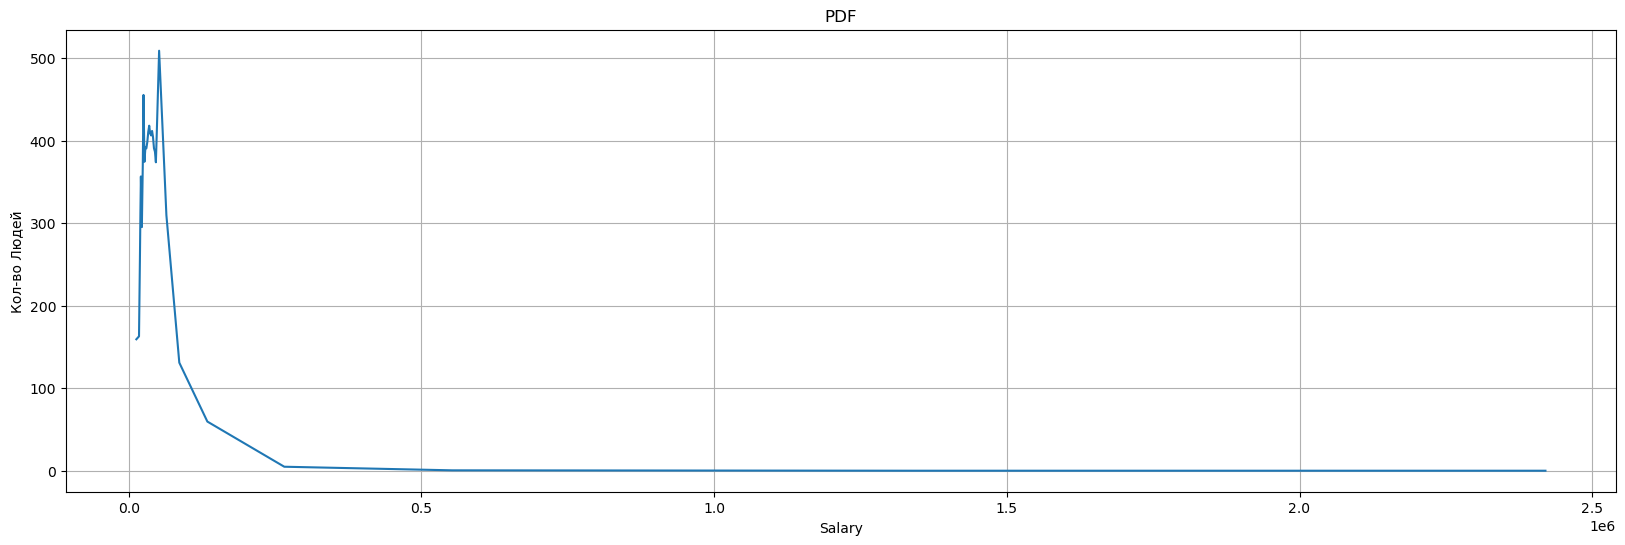

In [15]:
# Численно вычисленное PDF (сравнить)
df_2023['pdf_chisl'] = np.gradient(df_2023['cumsum'].values, df_2023['Ср зп'].values)

plt.figure(figsize=(20, 6))
plt.plot(df_2023['Ср зп'][:-1].values, df_2023['pdf_chisl'][:-1].values * num_workers_2023_bill)
plt.xlabel('Salary')
plt.ylabel('Кол-во Людей')
plt.title('PDF')
plt.grid(True)
plt.show()

In [16]:
## Зарплатные бакеты из биллютеней Росстат
buckets_2023 = np.log(parse_buckets(df_2023, 'Бакет'))

buckets_2021 = np.log(parse_buckets(df_2021, 'Бакет'))

buckets_2019 = np.log(parse_buckets(df_2019, 'Бакет'))

buckets_2017 = np.log(parse_buckets(df_2017, 'Бакет'))


In [17]:
# Верхние границы каждого бакета из биллютеней Росстат
upper_point_2023 = get_upper_bounds(buckets_2023)

upper_point_2021 = get_upper_bounds(buckets_2021)

upper_point_2019 = get_upper_bounds(buckets_2019)

upper_point_2017 = get_upper_bounds(buckets_2017)


## Сборка тотальных ежемесячных данных по рынку

In [ ]:
output_path = r'../source/fot.xls'

In [20]:
df_fot = pd.read_excel(output_path)

df_fot = df_fot.groupby(['report_dt', 'region']).agg({
    'fot': 'sum',
    'Value': 'sum'
}).reset_index()

df_fot = df_fot[df_fot['region'] == 'Российская Федерация']

df_fot['avg_salary'] = df_fot['fot'] / df_fot['Value']

df_fot = df_fot.set_index('report_dt', drop=False)

df_fot

,report_dt,region,fot,Value,avg_salary
report_dt,,,,,
2017-01-01,2017-01-01,Российская Федерация,1.480529e+12,43497055.0,34037.457678
2017-02-01,2017-02-01,Российская Федерация,1.534390e+12,43784013.0,35044.521205
2017-03-01,2017-03-01,Российская Федерация,1.644713e+12,43992391.0,37386.309450
2017-04-01,2017-04-01,Российская Федерация,1.709671e+12,44177643.0,38699.914304
2017-05-01,2017-05-01,Российская Федерация,1.729230e+12,44156266.0,39161.593823
...,...,...,...,...,...
2024-02-01,2024-02-01,Российская Федерация,3.347481e+12,43293455.0,77320.725799
2024-03-01,2024-03-01,Российская Федерация,3.748889e+12,43383719.7,86412.349551
2024-04-01,2024-04-01,Российская Федерация,3.585598e+12,43384119.7,82647.702213


## Получение количества людей / ср зп / фота за нужный месяц (тотал ежемес)

In [21]:
def get_total(date, df_fot=df_fot):
    fot_real = df_fot['fot'][date]
    num_workers = df_fot['Value'][date]
    avg_salary = df_fot['avg_salary'][date]

    print(f'{date}: fot_real = {fot_real}')
    print(f'{date}: num_workers = {num_workers}')
    print(f'{date}: avg_salary = {avg_salary}')
    
    return fot_real, num_workers, avg_salary

## Получение коэффициентов для работников для выравнивания

In [23]:
def get_workers_coeff(df):
    coeff_for_workers = df['Кол-во'].max() / df['Кол-во']
    coeff_for_workers = coeff_for_workers.values
    
    return coeff_for_workers

In [24]:
coeff_for_workers_2023 = get_workers_coeff(df_2023)

coeff_for_workers_2021 = get_workers_coeff(df_2021)

coeff_for_workers_2019 = get_workers_coeff(df_2019)

coeff_for_workers_2017 = get_workers_coeff(df_2017)

## Графики по рынку 

/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is depr

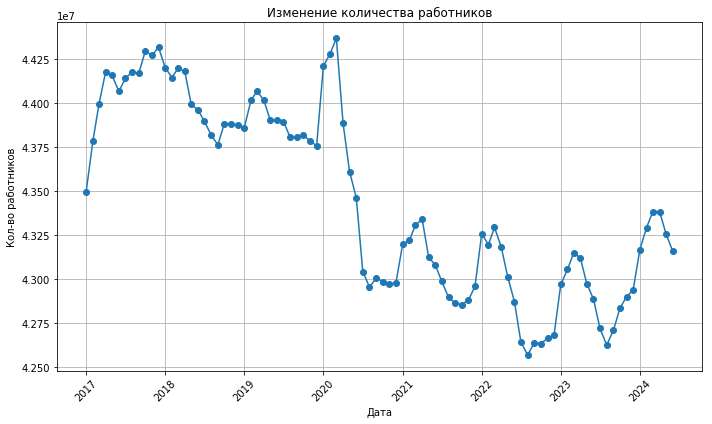

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df_fot['report_dt'], df_fot['Value'], marker='o')

plt.title('Изменение количества работников')
plt.xlabel('Дата')
plt.ylabel('Кол-во работников')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


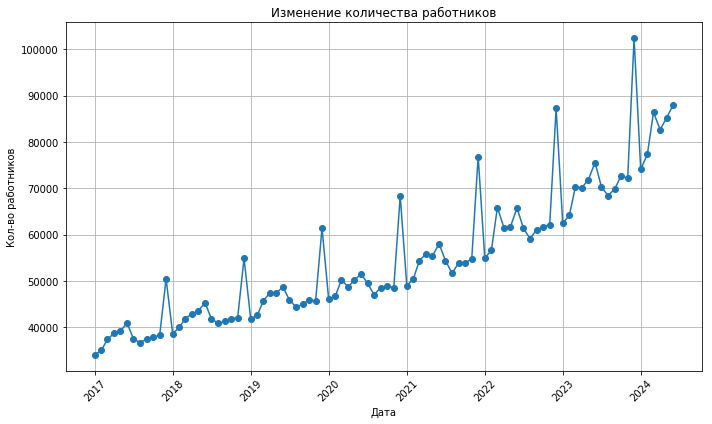

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(df_fot['report_dt'], df_fot['avg_salary'], marker='o')

plt.title('Изменение количества работников')
plt.xlabel('Дата')
plt.ylabel('Кол-во работников')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/venvs/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


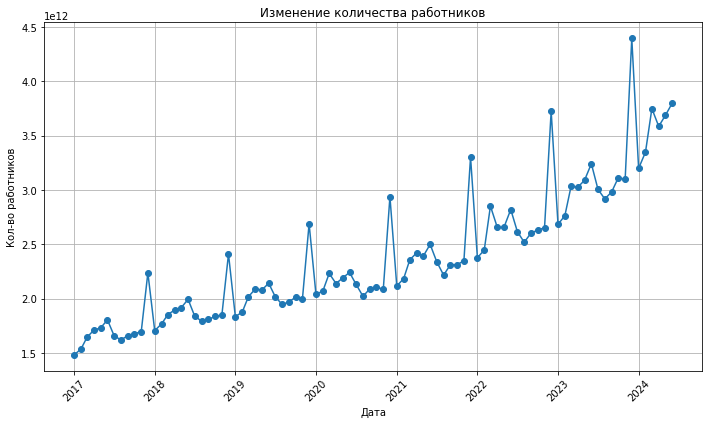

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df_fot['report_dt'], df_fot['fot'], marker='o')

plt.title('Изменение количества работников')
plt.xlabel('Дата')
plt.ylabel('Кол-во работников')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Ген Алгоритм GWO (первое приближение с ним можно найти)

Итерация 1, наименьшая ошибка: 441808863094.3286
Итерация 2, наименьшая ошибка: 31577001220.74723
Итерация 3, наименьшая ошибка: 24696303386.008427
Итерация 4, наименьшая ошибка: 20245249176.021336
Итерация 5, наименьшая ошибка: 17432480258.558086
Итерация 6, наименьшая ошибка: 14866160057.376757
Итерация 7, наименьшая ошибка: 14496793224.109425
Итерация 8, наименьшая ошибка: 14496793224.109425
Итерация 9, наименьшая ошибка: 14496793224.109425
Итерация 10, наименьшая ошибка: 14496793224.109425
Итерация 11, наименьшая ошибка: 14487181340.506323
Итерация 12, наименьшая ошибка: 14487181340.506323
Итерация 13, наименьшая ошибка: 14487181340.506323
Итерация 14, наименьшая ошибка: 14485491942.977623
Итерация 15, наименьшая ошибка: 14485491942.977623
Итерация 16, наименьшая ошибка: 14485491942.977623
Итерация 17, наименьшая ошибка: 14469304854.384546
Итерация 18, наименьшая ошибка: 14469304854.384546
Итерация 19, наименьшая ошибка: 14469304854.384546
Итерация 20, наименьшая ошибка: 1446930485

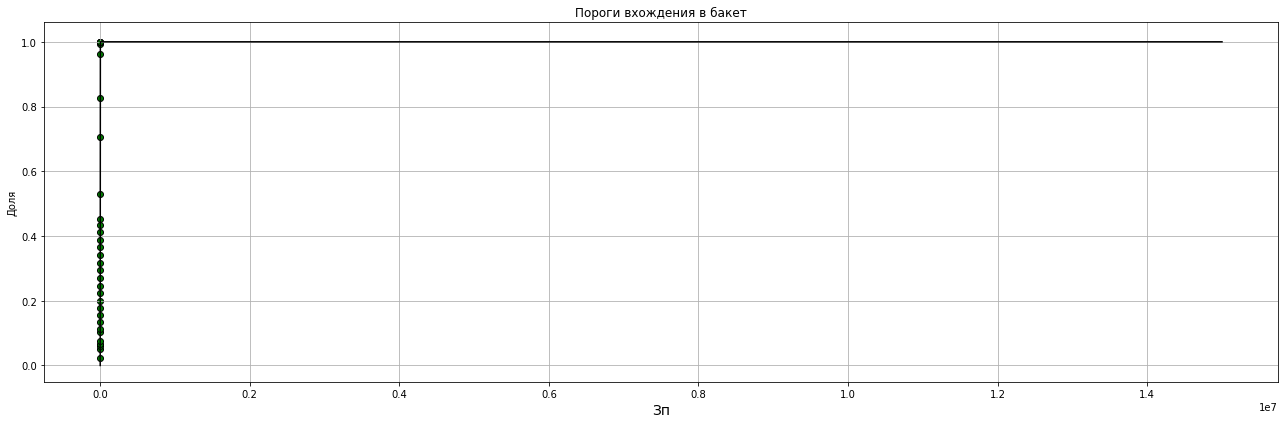

FOT = 306817355.13894314


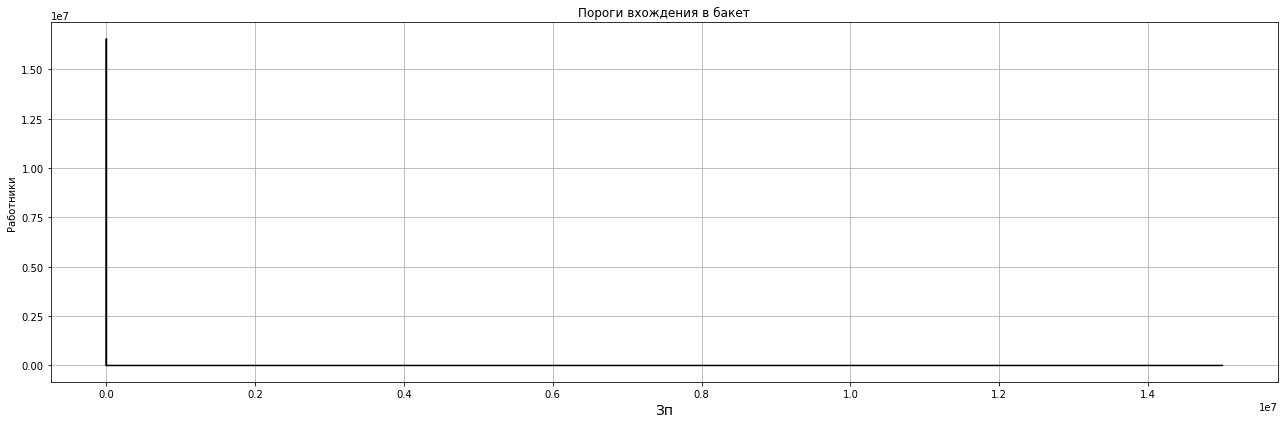

In [72]:
num_workers = num_workers_2023_bil
x = np.log(upper_point_2023)

y = df_2023['cumsum'].values

def gb2_cdf(x, a, b, p, q):
    term = (x / b) ** a
    return betainc(p, q, term / (1 + term))

def loss_func_gb2(params, x, y, num_workers):
    a, b, p, q = params
    y_pred = gb2_cdf(x, a, b, p, q)
    
    loss = ((y_pred - y) * num_workers) ** 2

    return np.mean(loss)


class GWO:
    def __init__(self, obj_func, lb, ub, dim, pop_size=100, max_iter=100, num_workers=0):
        self.obj_func = obj_func
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.population = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        self.alpha_pos = np.zeros(self.dim)
        self.beta_pos = np.zeros(self.dim)
        self.delta_pos = np.zeros(self.dim)
        self.alpha_score = float("inf")
        self.beta_score = float("inf")
        self.delta_score = float("inf")
        self.num_workers = num_workers
        
    def optimize(self, x, y):
            for iter in range(self.max_iter):
                for i in range(self.pop_size):
                    fitness = self.obj_func(self.population[i, :], x, y, self.num_workers)
                    
                    if fitness < self.alpha_score:
                        self.alpha_score = fitness
                        self.alpha_pos = self.population[i, :].copy()
                    elif fitness < self.beta_score:
                        self.beta_score = fitness
                        self.beta_pos = self.population[i, :].copy()
                    elif fitness < self.delta_score:
                        self.delta_score = fitness
                        self.delta_pos = self.population[i, :].copy()
                        
                a = 2 - iter * (2 / self.max_iter)
                for i in range(self.pop_size):
                    r1, r2 = np.random.random(2)
                    A1 = 2 * r1 - a
                    C1 = 2 * r2
                    D_alpha = abs(C1 * self.alpha_pos - self.population[i, :])
                    X1 = self.alpha_pos - A1 * D_alpha
                    
                    r1, r2 = np.random.random(2)
                    A2 = 2 * r1 - a
                    C2 = 2 * r2
                    D_beta = abs(C1 * self.beta_pos - self.population[i, :])
                    X2 = self.beta_pos - A1 * D_beta
                    
                    r1, r2 = np.random.random(2)
                    A3 = 2 * r1 - a
                    C3 = 2 * r2
                    D_delta = abs(C1 * self.delta_pos - self.population[i, :])
                    X3 = self.delta_pos - A1 * D_delta
                    
                    self.population[i, :] = (X1 + X2 + X3) / 3
                    
                self.population = np.clip(self.population, self.lb, self.ub)
                
                print(f'Итерация {iter+1}, наименьшая ошибка: {self.alpha_score}')
                
            return self.alpha_pos

lb = [0.01, 0.01, 0.01, 0.01]
ub = [25.0, 15.0, 10.0, 10.0]
dim = 4

x_range = np.log(np.linspace(1, 15_000_000, 30_000_000))

gwo = GWO(loss_func_gb2, lb, ub, dim, pop_size=10000, max_iter=100, num_workers=num_workers_2023_bil)

best_params = gwo.optimize(x, y)

a_cdf, b_cdf, p_cdf, q_cdf = best_params

print(f'a = {a_cdf}\nb_cdf = {b_cdf}\np_cdf = {p_cdf}\nq_cdf = {q_cdf}')

y_pred = gb2_cdf(x_range, a_cdf, b_cdf, p_cdf, q_cdf)
    
print(y_pred)

plt.figure(figsize=(18, 6))

plt.scatter(np.exp(x), y, color='g', edgecolor='black', label='Данные')
plt.plot(np.exp(x_range), y_pred, color='k', label='lognorm.cdf')

plt.xlabel('Зп', fontsize=14)
plt.ylabel('Доля')
plt.title(f'Пороги вхождения в бакет')

plt.grid(True)

plt.tight_layout()
plt.show()
    
# ----------------------------------------------------------------------------------- #
    
# Выход на функцию плотности через производную функции распределения (так лучше работает + меньше зависимостей)
pdf_from_cdf = np.diff(y_pred) / np.diff(np.exp(x_range))
        
# Новый рэнж (на 1 значение меньше из за взятия производной)
pdf_range_new = (x_range[:-1] + x_range[1:]) / 2
    
# Очищаем
x_range = None
y_pred = None
    
fot_pred = np.trapz(pdf_from_cdf * num_workers * np.exp(pdf_range_new), np.exp(pdf_range_new))
    
print(f'FOT = {fot_pred}')
    

plt.figure(figsize=(18, 6))

plt.plot(np.exp(pdf_range_new), pdf_from_cdf * num_workers, color='k', label='GB2.pdf')

plt.xlabel('Зп', fontsize=14)
plt.ylabel('Работники')
plt.title(f'Пороги вхождения в бакет')

plt.grid(True)

plt.tight_layout()
plt.show()

## CDF оптимизация 

In [39]:
result = []

a: 17.552549597605648 b: 10.751698404852315 p: 2.2604106706144727 q: 1.9225645983446413
rse: [-2.39375567e+05 -4.60068869e+04  1.00258726e+04  4.72407465e+04
  7.26815563e+04  3.39361352e+04  1.36002477e+04  6.67421263e+04
  3.45791329e+04  3.97563311e+04  2.03874397e+04 -3.30904346e+03
 -3.11693417e+04 -2.69602695e+04 -2.65966273e+04 -4.87802456e+04
 -3.24444193e+04 -1.86763671e+04 -2.99484882e+04 -5.18396379e+03
  1.65927476e+04  1.01909004e+04  2.25245267e+04  2.80005663e+04
  1.16404851e+04 -4.92501008e+04 -1.70293147e+04 -3.87276306e+03
 -2.93432054e+03 -2.10332668e+03  5.04613988e+01]
RMSE = 53184.49467215295

a: 17.55254960760565 b: 10.751698404852315 p: 2.2604106706144727 q: 1.9225645983446413
rse: [-2.39375565e+05 -4.60068846e+04  1.00258751e+04  4.72407491e+04
  7.26815590e+04  3.39361381e+04  1.36002508e+04  6.67421294e+04
  3.45791360e+04  3.97563341e+04  2.03874426e+04 -3.30904073e+03
 -3.11693392e+04 -2.69602672e+04 -2.65966254e+04 -4.87802439e+04
 -3.24444180e+04 -1.8676

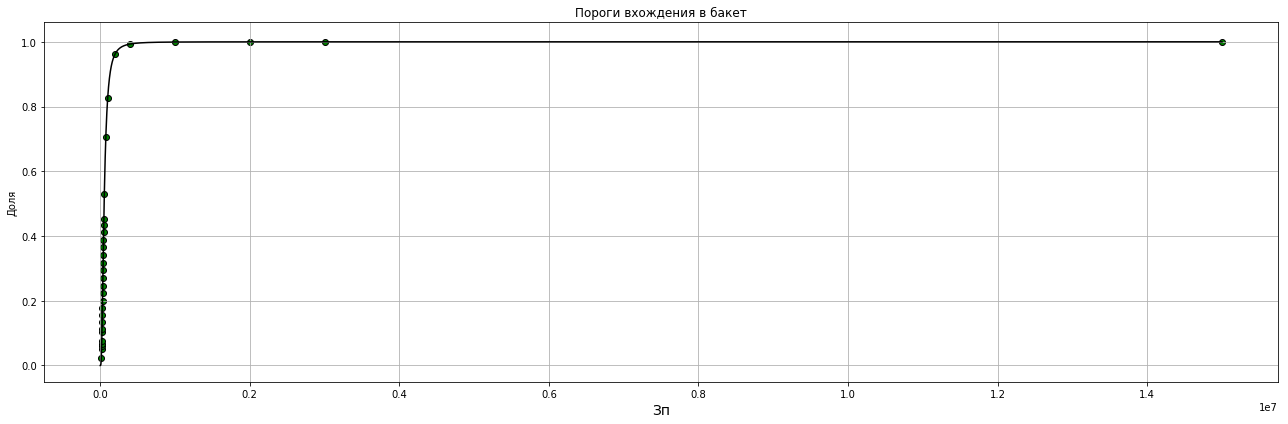

FOT pred = 1999224061073.0
Ошибка по ФОТу на биллютене = 0.01880790696891721


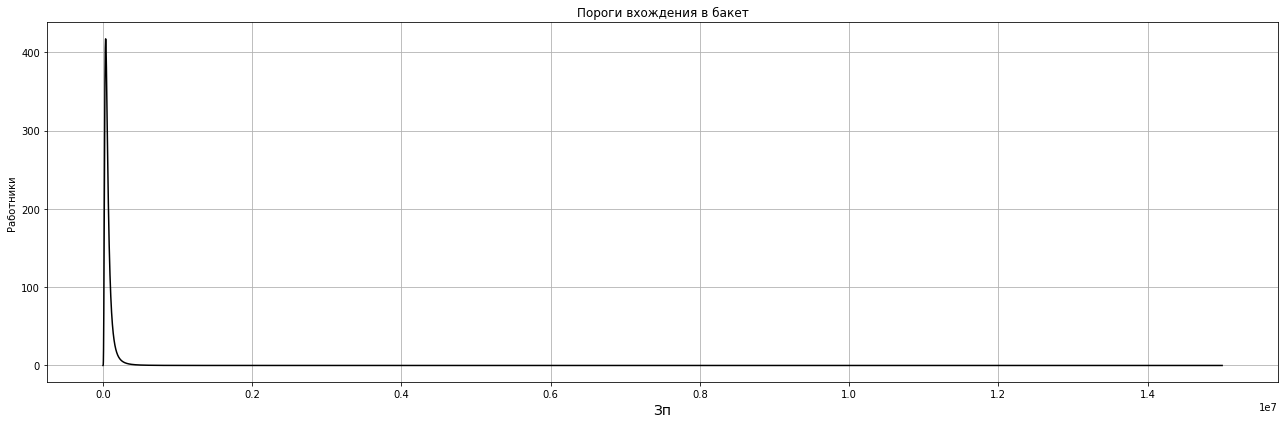

NameError: name 'result' is not defined

In [40]:
gc.collect()

# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2023
a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023 = custom_GB2(df_2023, upper_point_2023, num_workers_2023_bil, fot_2023_bil)

result.append({
    'year' : '2023',
    'a_cdf' : a_cdf_2023, 
    'b_cdf' : b_cdf_2023, 
    'p_cdf' : p_cdf_2023, 
    'q_cdf' : q_cdf_2023
})

a: 17.552549597605648 b: 10.751698404852315 p: 2.2604106706144727 q: 1.9225645983446413
rse: [ 3.05381072e+05  6.04488603e+05  8.60472502e+05  1.16628595e+06
  1.32672868e+06  1.55656943e+06  1.82750443e+06  2.09336120e+06
  2.35523789e+06  2.63091926e+06  2.85131517e+06  3.07847403e+06
  3.27636090e+06  3.48260593e+06  3.82667566e+06  4.10079178e+06
  4.32253798e+06  4.46780317e+06  4.51406306e+06  4.17505629e+06
  3.64351529e+06  3.09541611e+06  1.94786056e+06  4.05846880e+05
  7.03926242e+04  2.98982684e+03 -2.65020259e+02 -1.05142742e+03
  4.93947271e+01]
RMSE = 2640123.821182435

a: 17.55254960760565 b: 10.751698404852315 p: 2.2604106706144727 q: 1.9225645983446413
rse: [ 3.05381073e+05  6.04488604e+05  8.60472503e+05  1.16628595e+06
  1.32672869e+06  1.55656943e+06  1.82750443e+06  2.09336120e+06
  2.35523789e+06  2.63091926e+06  2.85131517e+06  3.07847403e+06
  3.27636090e+06  3.48260594e+06  3.82667566e+06  4.10079178e+06
  4.32253799e+06  4.46780317e+06  4.51406306e+06  4.1750

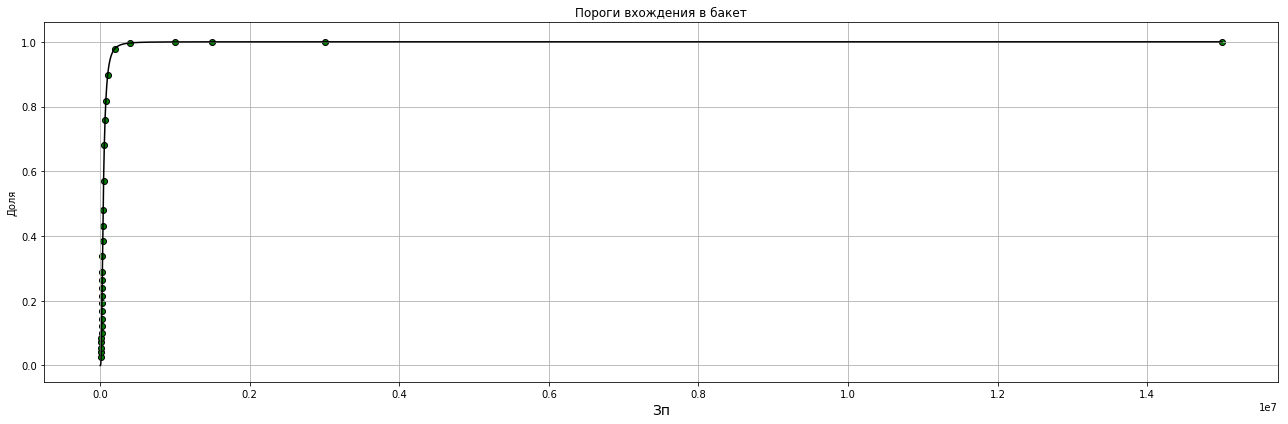

FOT pred = 1505885008579.7253
Ошибка по ФОТу на биллютене = 0.027506829329773885


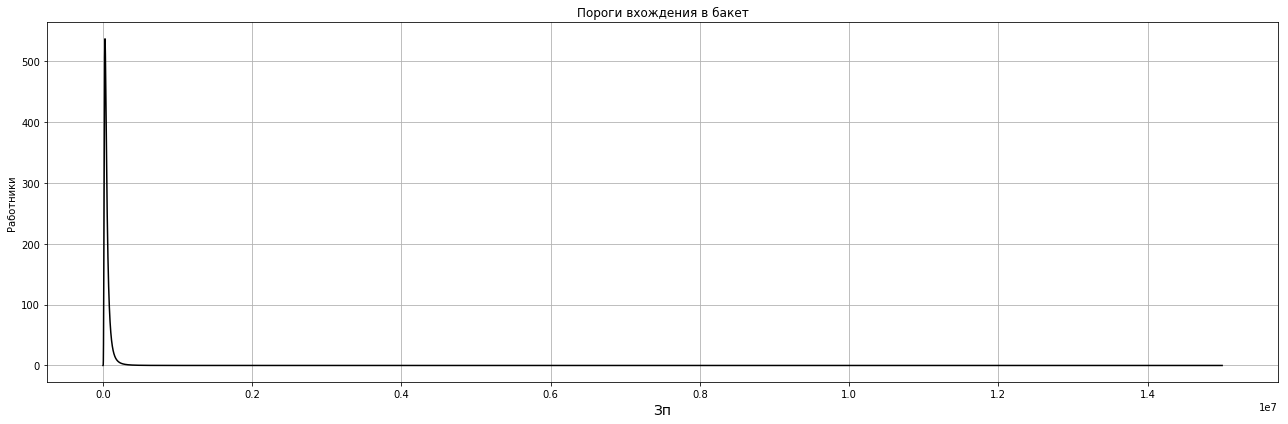

In [41]:
gc.collect()

# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2021
a_cdf_2021, b_cdf_2021, p_cdf_2021, q_cdf_2021 = custom_GB2(df_2021, upper_point_2021, num_workers_2021_bil, fot_2021_bil)

result.append({
    'year' : '2021',
    'a_cdf' : a_cdf_2021, 
    'b_cdf' : b_cdf_2021, 
    'p_cdf' : p_cdf_2021, 
    'q_cdf' : q_cdf_2021
})

a: 17.552549597605648 b: 10.751698404852315 p: 2.2604106706144727 q: 1.9225645983446413
rse: [5.39656732e+05 9.29200534e+05 1.31082892e+06 1.58335596e+06
 1.92623959e+06 2.26609004e+06 2.65545319e+06 3.05566498e+06
 3.44247635e+06 3.82642761e+06 4.15066574e+06 4.47195992e+06
 4.80616593e+06 5.11627369e+06 5.67615917e+06 6.13629637e+06
 6.48553570e+06 6.74050830e+06 6.93914459e+06 6.81835097e+06
 6.55614317e+06 5.70672227e+06 4.38603098e+06 2.76273446e+06
 3.57403133e+05 5.83824021e+04 8.49948415e+03 4.86397588e+01]
RMSE = 4218031.887577047

a: 17.55254960760565 b: 10.751698404852315 p: 2.2604106706144727 q: 1.9225645983446413
rse: [5.39656733e+05 9.29200535e+05 1.31082893e+06 1.58335596e+06
 1.92623959e+06 2.26609004e+06 2.65545319e+06 3.05566499e+06
 3.44247636e+06 3.82642761e+06 4.15066574e+06 4.47195992e+06
 4.80616593e+06 5.11627369e+06 5.67615917e+06 6.13629638e+06
 6.48553571e+06 6.74050830e+06 6.93914459e+06 6.81835097e+06
 6.55614317e+06 5.70672227e+06 4.38603098e+06 2.76273446

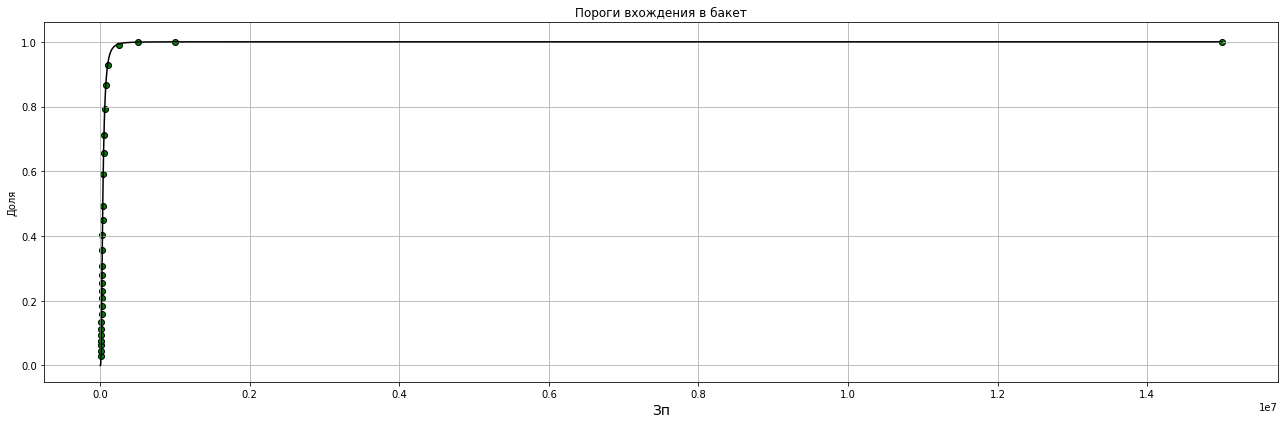

FOT pred = 1248330061727.4001
Ошибка по ФОТу на биллютене = 0.03319585590333274


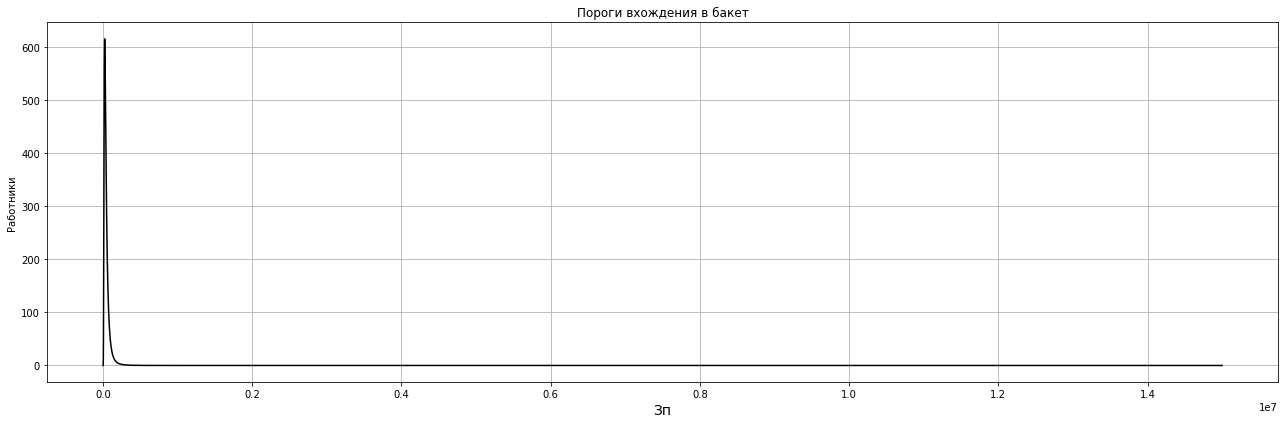

NameError: name 'result' is not defined

In [41]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2019
a_cdf_2019, b_cdf_2019, p_cdf_2019, q_cdf_2019 = custom_GB2(df_2019, upper_point_2019, num_workers_2019_bil, fot_2019_bil)

result.append({
    'year' : '2019',
    'a_cdf' : a_cdf_2019, 
    'b_cdf' : b_cdf_2019, 
    'p_cdf' : p_cdf_2019, 
    'q_cdf' : q_cdf_2019
})

In [ ]:
# Нахождение оптимальных параметров GB распределения, описывающих cdf распределение биллютеня от Росстат за 2017
a_cdf_2017, b_cdf_2017, p_cdf_2017, q_cdf_2017 = custom_GB2(df_2017, upper_point_2017, num_workers_2017_bil, fot_2017_bil)

result.append({
    'year' : '2017',
    'a_cdf' : a_cdf_2017, 
    'b_cdf' : b_cdf_2017, 
    'p_cdf' : p_cdf_2017, 
    'q_cdf' : q_cdf_2017
})

In [ ]:
result_df = pd.DataFrame(result)
result_df.to_excel('result.xlsx')

## Получение медианной зп по параметрам

In [69]:
# Медианная зп

def gb2_cdf(x, a, b, p, q):
    term = (x / b) ** a
    return betainc(p, q, term / (1 + term))

def obj(x, a, b, p, q):
    return abs(gb2_cdf(np.log(x), a, b, p, q) - 0.5000000)

result = minimize(obj, a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023, x0 = 45000, method='bfgs')

print(result.x[0])

gb2_cdf(np.log(result.x[0]), a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023)

NameError: name 'a_cdf_2023' is not defined

## Тестирование моделей обученной на CDF

In [ ]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2023 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_cdf_2023, b_cdf_2023,
                                                                        p_cdf_2023, q_cdf_2023, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 59576972957.7], 
    'true_num_workers' : [23231070.9, 3779433, 887636, 185304, 24400],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 2441688.2]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final['fot_error'] = 1 - result_2023_final['fot'] / result_2023_final['true_fot']
result_2023_final['num_workers_error'] = 1 - result_2023_final['num_workers'] / result_2023_final['true_num_workers']
result_2023_final['avg_salary_error'] = 1 - result_2023_final['avg_salary'] / result_2023_final['true_avg_salary']
result_2023_final.to_excel('result_2023_final.xlsx')
result_2023_final


 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.129625e+12,2.321550e+07,4.865821e+04,1.132340e+12,23231070.9,4.874249e+04,0.002398,0.000670,0.001729
1,100000.1-200000,5.132769e+11,3.841836e+06,1.336020e+05,5.074188e+11,3779433.0,1.342579e+05,-0.011545,-0.016511,0.004886
2,200000.1-400000,2.252595e+11,8.570013e+05,2.628458e+05,2.358009e+11,887636.0,2.656505e+05,0.044705,0.034513,0.010558
3,400000.1-1000000,9.589364e+10,1.728219e+05,5.548666e+05,1.024096e+11,185304.0,5.526575e+05,0.063626,0.067360,-0.003997
4,1000000-15000001,3.516741e+10,2.062010e+04,1.705409e+06,5.957697e+10,24400.0,2.441688e+06,0.409715,0.154914,0.301545


In [63]:


buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

num_workers_2021_bill = 27513690

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_cdf_2021, b_cdf_2021, p_cdf_2021, q_cdf_2021, num_workers_2021_bill)
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 887636, 501879, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})      
       
result_2021 = pd.DataFrame(result_2021)
result_2021_final = pd.merge(result_2021, true_2021, on='bucket')
result_2021_final['fot_error'] = 1 - result_2021_final['fot'] / result_2021_final['true_fot']
result_2021_final['num_workers_error'] = 1 - result_2021_final['num_workers'] / result_2021_final['true_num_workers']
result_2021_final['avg_salary_error'] = 1 - result_2021_final['avg_salary'] / result_2021_final['true_avg_salary']
result_2021_final.to_excel('result_2021_final.xlsx')
result_2021_final


 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.020609e+12,2.469643e+07,4.132619e+04,1.019722e+12,24676470,4.132366e+04,-0.000870,-0.000809,-0.000061
1,100000.1-200000,2.997485e+11,2.259738e+06,1.326474e+05,2.971629e+11,2217132,1.342579e+05,-0.008701,-0.019217,0.011996
2,200000.1-400000,1.204479e+11,4.595994e+05,2.620709e+05,1.327880e+11,887636,2.645818e+05,0.092931,0.482221,0.009490
3,400000.1-1000000,4.866472e+10,8.803525e+04,5.527805e+05,5.663783e+10,501879,5.601850e+05,0.140774,0.824589,0.013218
4,1000000-15000001,1.641009e+10,9.803040e+03,1.673809e+06,4.216857e+10,17103,2.465507e+06,0.610845,0.426823,0.321109


## Оптимизация на детальных бакетных данных

a_start = 17.55251736036164
b_start = 10.750478031897766
p_start = 2.2616848788649073
q_start = 1.92010663729456


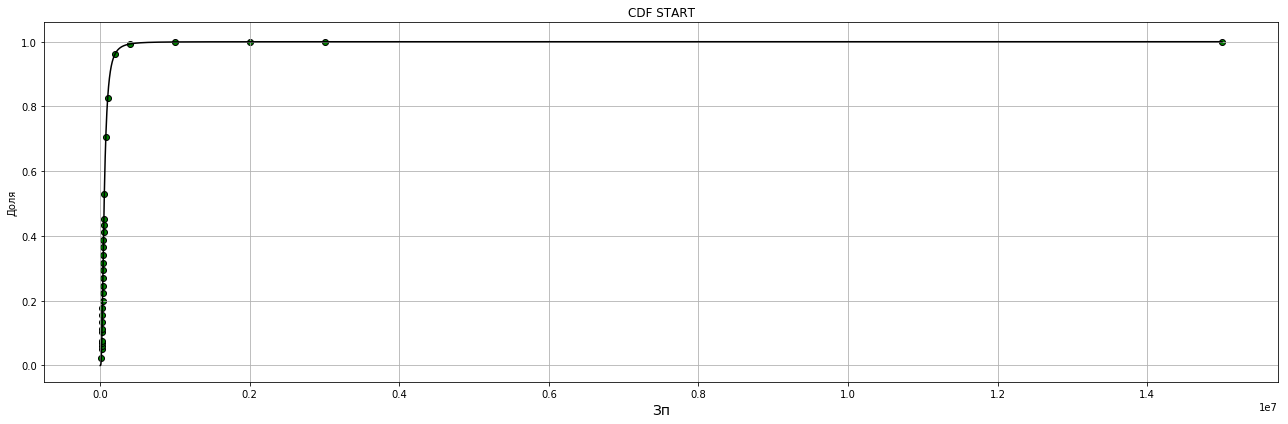

/opt/venvs/anaconda/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


a: 17.55251736036164 b: 10.750478031897766 p: 2.2616848788649073 q: 1.92010663729456
detailed workers_MSE: [[57081342912.0373, 37421998446.12283, 3143875981.454543, 1387651965.797588, 649041299.7538772, 1497897116.3183856, 412075517.17668396, 2828424376.589517, 1031421752.8026607, 27390923.916492905, 372541437.16684943, 557732684.7593784, 770985496.6387999, 18624792.256431866, 233630.65660702577, 486322190.3210354, 271493804.5244944, 193675273.03451115, 123408166.16885698, 621304788.9620057, 481448869.2232355, 38867261.97756651, 166172862.97149277, 46004663.533164985, 251595321.08060434, 3894071107.5441685, 938464202.6264473, 155798388.5770911, 690084.4331552122, 657465.1931005107, 4571698.465306175]]
detailed FOT_RMSE:    [8.378137722196025e+18, 1.130994653119146e+19, 1.1287250458165363e+18, 5.452006369758821e+17, 2.7362892781146538e+17, 7.529033568278164e+17, 2.3578372090215517e+17, 1.751393637237708e+18, 7.578719701356579e+17, 2.0009523125895948e+16, 3.403691793243916e+17, 5.4943178

In [ ]:
## Получение оптимальных параметрах на детальных бакетных данных за 2023

gc.collect()
a_pdf_2023, b_pdf_2023, p_pdf_2023, q_pdf_2023 = loss_pdf_gb2_fot(df_2023, a_cdf_2023, b_cdf_2023, p_cdf_2023, q_cdf_2023, fot_real=fot_2023_bil, 
                                 num_workers=num_workers_2023_bil, avg_salary=avg_salary_2023_bil, coeff=coeff_for_workers_2023, 
                                     upper_point=upper_point_2023, buckets=buckets_2023)

result.append({
    'year' : '2023',
    'a_pdf' : a_pdf_2023, 
    'b_pdf' : b_pdf_2023, 
    'p_pdf' : p_pdf_2023, 
    'q_pdf' : q_pdf_2023
})

In [ ]:
## Получение оптимальных параметрах на детальных бакетных данных за 2021

gc.collect()
a_pdf_2021, b_pdf_2021, p_pdf_2021, q_pdf_2021 = loss_pdf_gb2_fot(df_2021, a_cdf_2021, b_cdf_2021, p_cdf_2021, q_cdf_2021, fot_real=fot_2021_bill, 
                                 num_workers=num_workers_2021_bill, avg_salary=avg_salary_2021_bill, coeff=coeff_for_workers_2021, 
                                    upper_point=upper_point_2021, buckets=buckets_2021)

result.append({
    'year' : '2021',
    'a_pdf' : a_pdf_2021, 
    'b_pdf' : b_pdf_2021, 
    'p_pdf' : p_pdf_2021, 
    'q_pdf' : q_pdf_2021
})

In [ ]:
gc.collect()
a_pdf_2019, b_pdf_2019, p_pdf_2019, q_pdf_2019 = loss_pdf_gb2_fot(df_2019, a_cdf_2019, b_cdf_2019, p_cdf_2019, q_cdf_2019, fot_real=fot_2019_bill, 
                                 num_workers=num_workers_2019_bill, avg_salary=avg_salary_2019_bill, coeff=coeff_for_workers_2019, 
                                    upper_point=upper_point_2019, buckets=buckets_2019)

result.append({
    'year' : '2019',
    'a_pdf' : a_pdf_2019, 
    'b_pdf' : b_pdf_2019, 
    'p_pdf' : p_pdf_2019, 
    'q_pdf' : q_pdf_2019
})

In [ ]:
## Получение оптимальных параметрах на детальных бакетных данных за 2021

gc.collect()
a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017 = loss_pdf_gb2_fot(df_2017, a_cdf_2017, b_cdf_2017, p_cdf_2017, q_cdf_2017, fot_real=fot_2017_bill, 
                                 num_workers=num_workers_2017_bill, avg_salary=avg_salary_2017_bill, coeff=coeff_for_workers_2017, 
                                    upper_point=upper_point_2017, buckets=buckets_2017)

result.append({
    'year' : '2017',
    'a_pdf' : a_pdf_2017, 
    'b_pdf' : b_pdf_2017, 
    'p_pdf' : p_pdf_2017, 
    'q_pdf' : q_pdf_2017
})

In [ ]:
result_df = pd.DataFrame(result)
result_df.to_excel('result_2017_last.xls')

In [ ]:
MSE = np.array([9.418256399268664e+19, 2.84665179546153e+17, 9.524763368833728e+16, 4.100848978638809e+17, 
                7.149654234010543e+17, 2.2668324447283986e+19, 2.732982658043418e+18, 5.79456277824721e+17, 
                6.404427608012493e+18, 1.1268609161179455e+18, 1.6505093680905902e+18, 8.838836860933377e+17, 
                3.957113404649952e+17, 8.539693576606875e+17, 1.539570321925759e+18, 6.083675662080448e+17, 
                7.024487427303304e+18, 8.134661254113937e+18, 4.958510466741791e+18, 1.5205340262351366e+19, 
                1.5747148532480616e+19, 7.823002046234857e+18, 1.838990283626281e+20, 1.2867487323073494e+21, 
                3.243657794135089e+20, 6.112939802649085e+20, 1.6183187241498733e+19, 1.5733658325984246e+21, 
                3.5546366399581035e+20, 5.6585087409815716e+19, 8.004936402883702e+20])

peoples = df_2023['Кол-во'].values

prop = MSE / peoples
prop = prop / min(prop)

print(prop)

[3.81296024e+02 1.07700727e+00 1.00000000e+00 4.39533411e+00
 7.62736717e+00 8.50982373e+01 2.92145724e+01 2.48777262e+00
 3.02427001e+01 4.77448108e+00 7.10144789e+00 3.75263733e+00
 1.66053969e+00 3.42189044e+00 6.17969035e+00 2.56221107e+00
 2.82632434e+01 3.37991023e+01 2.05677987e+01 6.48683451e+01
 6.92182472e+01 3.70783815e+01 2.35590608e+02 7.09974030e+02
 2.58860174e+02 4.40712510e+02 4.96776713e+01 2.31354133e+04
 5.54902945e+04 4.74261995e+04 5.90413823e+05]


## Тестирование моделей обученных на деталке

In [32]:
parameters = pd.read_excel('parameters_by_years.xlsx')

a_pdf_2023, b_pdf_2023, p_pdf_2023, q_pdf_2023 = parameters[parameters['year'] == 2023][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

a_pdf_2021, b_pdf_2021, p_pdf_2021, q_pdf_2021 = parameters[parameters['year'] == 2021][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

a_pdf_2019, b_pdf_2019, p_pdf_2019, q_pdf_2019 = parameters[parameters['year'] == 2019][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

a_pdf_2017, b_pdf_2017, p_pdf_2017, q_pdf_2017 = parameters[parameters['year'] == 2017][['a_pdf', 'b_pdf', 'p_pdf', 'q_pdf']].values.T

In [ ]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2023 = []

print(f'a :{a_pdf_2023}, b: {b_pdf_2023}, p: {p_pdf_2023}, q: {q_pdf_2023}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_pdf_2023, b_pdf_2023,
                                                                        p_pdf_2023, q_pdf_2023, num_workers_2023_bill)
        result_2023.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2023 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1132340133606.4, 507418803557.1, 235800886118.4, 102409556954.8, 59576972957.7], 
    'true_num_workers' : [23231071, 3779433, 887636, 185304, 24400],
    'true_avg_salary' : [48742.48538, 134257.9, 265650.5, 552657.5, 2441688.2]
})      
       
result_2023 = pd.DataFrame(result_2023)
result_2023_final_det = pd.merge(result_2023, true_2023, on='bucket')
result_2023_final_det['fot_error'] = 1 - result_2023_final_det['fot'] / result_2023_final_det['true_fot']
result_2023_final_det['num_workers_error'] = 1 - result_2023_final_det['num_workers'] / result_2023_final_det['true_num_workers']
result_2023_final_det['avg_salary_error'] = 1 - result_2023_final_det['avg_salary'] / result_2023_final_det['true_avg_salary']
result_2023_final_det.to_excel('result_2023_final_det.xlsx')
result_2023_final_det

In [ ]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

print(f'a :{a_pdf_2021}, b: {b_pdf_2021}, p: {p_pdf_2021}, q: {q_pdf_2021}')

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_pdf_2021, b_pdf_2021, p_pdf_2021, 
                                                                        q_pdf_2021, num_workers_2021_bill)
        
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 887636, 501879, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})      
       
result_2021 = pd.DataFrame(result_2021)
result_2021_final_det = pd.merge(result_2021, true_2021, on='bucket')
result_2021_final_det['fot_error'] = 1 - result_2021_final_det['fot'] / result_2021_final_det['true_fot']
result_2021_final_det['num_workers_error'] = 1 - result_2021_final_det['num_workers'] / result_2021_final_det['true_num_workers']
result_2021_final_det['avg_salary_error'] = 1 - result_2021_final_det['avg_salary'] / result_2021_final_det['true_avg_salary']
result_2021_final_det.to_excel('result_2021_final_det.xlsx')
result_2021_final_det

In [ ]:
buckets = [(1, 100_000), (100_000.1, 250_000), (250_000.1, 500_000), (500_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2019 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_pdf_2019, b_pdf_2019, p_pdf_2019, 
                                                                        q_pdf_2019, num_workers_2019_bill)
        
        result_2019.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2019 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [935732543116.4, 243171300459.4, 60726298607.6, 25032269690.6, 26529171699.5], 
    'true_num_workers' : [25143952, 1716783, 183725, 37414, 11287],
    'true_avg_salary' : [37215.01457, 141643.6, 330527.4, 669060.5, 2350493.3]
})      
       
result_2019 = pd.DataFrame(result_2019)
result_2019_final_det = pd.merge(result_2019, true_2019, on='bucket')
result_2019_final_det['fot_error'] = 1 - result_2019_final_det['fot'] / result_2019_final_det['true_fot']
result_2019_final_det['num_workers_error'] = 1 - result_2019_final_det['num_workers'] / result_2019_final_det['true_num_workers']
result_2019_final_det['avg_salary_error'] = 1 - result_2019_final_det['avg_salary'] / result_2019_final_det['true_avg_salary']
result_2019_final_det.to_excel('result_2019_final_det.xlsx')
result_2019_final_det

In [ ]:
buckets = [(1, 100_000), (100_000.1, 250_000), (250_000.1, 500_000), (500_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2017 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end,  a_pdf_2017, b_pdf_2017, 
                                                                        p_pdf_2017, q_pdf_2017, num_workers_2017_bill)
        result_2017.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2017 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [830525402816.38, 152356101325.37, 36983880753.97, 14537970128.41, 16475678198.32], 
    'true_num_workers' : [25790866, 1084115.77, 111263.38, 21836.84, 6988.38],
    'true_avg_salary' : [32202.30749, 140534.9, 330527.4, 332399.4, 665754.3]
})      
       
result_2017 = pd.DataFrame(result_2017)
result_2017_final_det = pd.merge(result_2017, true_2017, on='bucket')
result_2017_final_det['fot_error'] = 1 - result_2017_final_det['fot'] / result_2017_final_det['true_fot']
result_2017_final_det['num_workers_error'] = 1 - result_2017_final_det['num_workers'] / result_2017_final_det['true_num_workers']
result_2017_final_det['avg_salary_error'] = 1 - result_2017_final_det['avg_salary'] / result_2017_final_det['true_avg_salary']
result_2017_final_det.to_excel('result_2019_final_det.xlsx')
result_2017_final_det

## Экстраполяция - то что нужно сейчас подумать придумать!!


In [ ]:
buckets = [(2, 100_000), (100_000.1, 150_000), (150_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000.01, 100_000_000)]

df_fot_2023 = df_fot[df_fot['report_dt'].between('2022-04-01', '2024-4-01')]

result_2023 = []

for index, row in df_fot_2023[['report_dt', 'fot', 'Value', 'avg_salary']].iterrows():
    date = row['report_dt']
    fot_real = row['fot']
    num_workers = row['Value']
    avg_salary = row['avg_salary']
    
    print(f'\n WORKING WITH DATE {date} \n')
    
    a_start, b_start, p_start, q_start = a_pdf_2023, b_pdf_2023, p_pdf_2023, q_pdf_2023
    
    a_opt_month, b_opt_month, p_opt_month, q_opt_month  = calibrate_on_date(a_start, b_start, p_start, 
                                                                            q_start, fot_real, num_workers, avg_salary)
    
    for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_month, b_opt_month, 
                                                                        p_opt_month, q_opt_month, num_workers)
        result_2023.append({
            'report_dt' : date, 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

df_2023 = pd.DataFrame(result_2023)


 WORKING WITH DATE 2022-04-01 00:00:00 


 CALIBRATING 

a_start = 21.14995231485007
b_start = 10.787480235439475
p_start = 1.6297935487836452
q_start = 1.4281349156942242


/opt/venvs/anaconda/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


a_opt_new = 21.892376222882945
b_opt_new = 10.703453852256349
p_opt_new = 1.5971581703020692
q_opt_new = 1.4763624059858473
real FOT = 2655791880417.89
pred FOT = 2655791880417.89
ERROR = 0.0
real num_workers = 43184000.300000004
pred num_workers = 43183936.671181284
ERROR_num_workers = -1.4734371995839268e-06
real avg_salary = 61499.441042239196
pred avg_salary = 61499.53165780339
ERROR_avg_salary = 1.4734350286538245e-06

 CALCULATING 2-100000 


 CALCULATING 100000.1-150000 


 CALCULATING 150000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000.01-100000000 


 WORKING WITH DATE 2022-05-01 00:00:00 


 CALIBRATING 

a_start = 21.14995231485007
b_start = 10.787480235439475
p_start = 1.6297935487836452
q_start = 1.4281349156942242
a_opt_new = 21.818050908226724
b_opt_new = 10.704382602474066
p_opt_new = 1.6019142742408474
q_opt_new = 1.4787354665468355
real FOT = 2654171318280.71
pred FOT = 2654171318280.71
ERROR = 0.0
real num_workers = 43014120.3
pred num_workers = 

In [ ]:
df_2023.to_excel(r'market_share_2022_2024.xls', 
                      index=False)

In [ ]:
df_2023.to_excel(r'\\admira203.ca.sbrf.ru\vol4\HQRB_VARM\Клиентские пути\Влад\FOT\bucket_in_years\2023_new.xls', 
                      index=False)

## 2022 - 2023 года график с доверительным интервалом

In [ ]:
df_2022_2023 = pd.read_excel(r'2022_2023_23_10.xls')
df_2022_2023 = df_2022_2023.groupby(by='report_dt').agg({
    'fot' : 'sum',
    'num_workers' : 'sum'
}  
).reset_index()

df_2022_2023['avg_salary'] = df_2022_2023['fot'] / df_2022_2023['num_workers']
df_2022_2023['report_dt'] = pd.to_datetime(df_2022_2023['report_dt'])
df_2022_2023

,report_dt,fot,num_workers,avg_salary
0,2022-01-01,2.381874e+12,4.325842e+07,55061.518514
1,2022-02-01,2.452901e+12,4.319673e+07,56784.411645
2,2022-03-01,2.864578e+12,4.329422e+07,66165.363669
3,2022-04-01,2.665865e+12,4.318397e+07,61732.744726
4,2022-05-01,2.664349e+12,4.301409e+07,61941.313640
5,2022-06-01,2.832711e+12,4.287347e+07,66071.433708
6,2022-07-01,2.626052e+12,4.264330e+07,61581.814122
7,2022-08-01,2.526116e+12,4.257095e+07,59338.959892
8,2022-09-01,2.613348e+12,4.264010e+07,61288.504441
9,2022-10-01,2.639249e+12,4.263549e+07,61902.628017


In [41]:
df_fact_2022_2023 = df_fot[df_fot['report_dt'].between('2022-01-01', '2024-06-01')]
df_fact_2022_2023 = df_fact_2022_2023.rename(columns={'Value' : 'num_workers'})
df_fact_2022_2023['report_dt'] = pd.to_datetime(df_fact_2022_2023['report_dt'])
df_fact_2022_2023

,report_dt,region,fot,num_workers,avg_salary
report_dt,,,,,
2022-01-01,2022-01-01,Российская Федерация,2.375718e+12,43258442.6,54919.174637
2022-02-01,2022-02-01,Российская Федерация,2.445864e+12,43196751.0,56621.482292
2022-03-01,2022-03-01,Российская Федерация,2.851045e+12,43294249.7,65852.734974
2022-04-01,2022-04-01,Российская Федерация,2.655792e+12,43184000.3,61499.441042
2022-05-01,2022-05-01,Российская Федерация,2.654171e+12,43014120.3,61704.651862
2022-06-01,2022-06-01,Российская Федерация,2.819389e+12,42873497.6,65760.646997
2022-07-01,2022-07-01,Российская Федерация,2.616207e+12,42643329.2,61350.918142
2022-08-01,2022-08-01,Российская Федерация,2.517727e+12,42570976.2,59141.861360
2022-09-01,2022-09-01,Российская Федерация,2.603701e+12,42640131.5,61062.218886


In [42]:
from scipy.stats import t, norm

def plot_with_conf(df_fact, df_model, column, alpha=0.05):
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(x=df_fact['report_dt'], y=df_fact[column], color='green', label='Данные Факт')
    
    mean_fact = df_fact[column].mean()
    std_fact = np.std(df_fact[column], ddof=1)
    n = len(df_fact)
    
    t_value = t.ppf(1 - alpha / 2, df=n-1)
    # z_value = norm.ppf(1 - alpha / 2)
    
    ci_95 = t_value * std_fact / np.sqrt(n)
    # ci_95 = z_value * std_fact / np.sqrt(n)
    
    plt.fill_between(df_fact['report_dt'], df_fact[column] - ci_95, df_fact[column] + ci_95, color='green', 
                     alpha=0.2, label=f'{int((1-alpha)*100)}% доверительный интервал', hatch='//')
    
    sns.lineplot(x=df_model['report_dt'], y=df_model[column], color='blue', label='Данные Модель')
    
    plt.title(f'Сравнение модельных и фактических данных {column}')
    plt.xlabel('Дата')
    plt.ylabel(column)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim(df_model['report_dt'].min(), df_model['report_dt'].max())
    plt.show()  

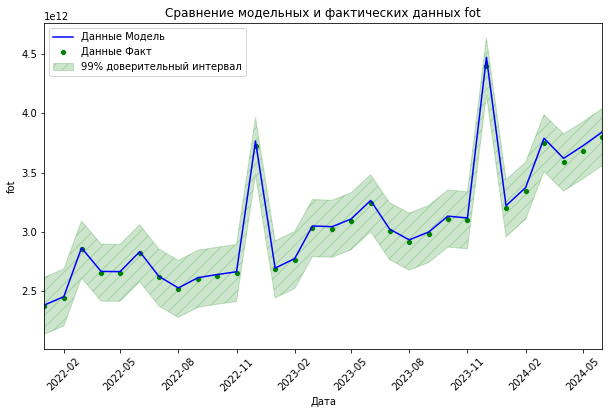

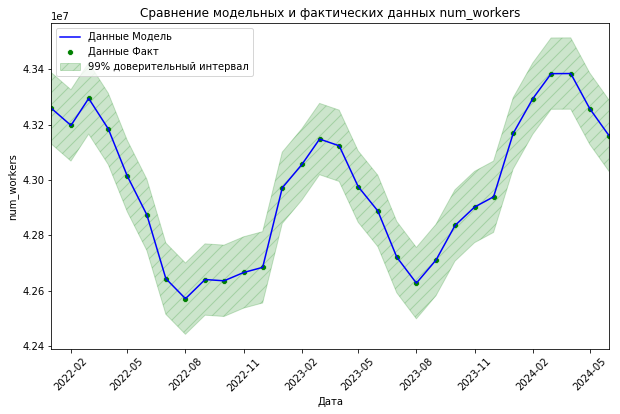

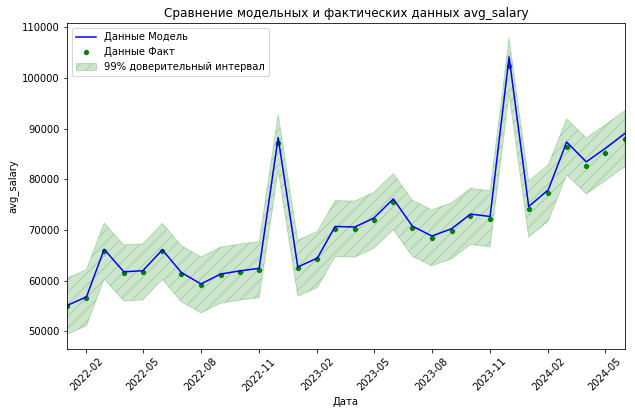

In [43]:
alpha = 0.01

for column in ['fot', 'num_workers', 'avg_salary']:
    plot_with_conf(df_fact_2022_2023, df_2022_2023, column, alpha=alpha)

## 2021 Тестирование экстраполяции

In [40]:
df_2021_detailed = df_fot[df_fot['report_dt'] == '2023-04-01']
df_2021_detailed

,report_dt,region,fot,Value,avg_salary
report_dt,,,,,
2023-04-01,2023-04-01,Российская Федерация,3.025786e+12,43123120.2,70166.210001


In [44]:
fot_train, num_workers_train, avg_salary_train = df_2021_detailed[['fot', 'Value', 'avg_salary']].values.T

In [ ]:
# a = 20.59417753558644
# b_cdf = 11.284144023181453
# p_cdf = 1.0752867698890636
# q_cdf = 2.1093254680828983

In [49]:
a_opt_new, b_opt_new, p_opt_new, q_opt_new  = calibrate_on_date(a_start=20.59417753558644, b_start=11.284144023181453, 
                                                                p_start=1.0752867698890636, q_start=2.1093254680828983, 
                                                                fot_real=fot_train, num_workers=num_workers_train, 
                                                                avg_salary=avg_salary_train)


 CALIBRATING 

a_start = 20.59417753558644
b_start = 11.284144023181453
p_start = 1.0752867698890636
q_start = 2.1093254680828983
FOT RMSE:        [2.54450993e+11]
num_workers MSE: [9.40933462]
avg_salary MSE : [3.48166909e+11]

FOT RMSE:        [2.54450993e+11]
num_workers MSE: [9.40933417]
avg_salary MSE : [3.48166909e+11]

FOT RMSE:        [2.54450965e+11]
num_workers MSE: [9.40933476]
avg_salary MSE : [3.48166833e+11]

FOT RMSE:        [2.54450976e+11]
num_workers MSE: [9.40933444]
avg_salary MSE : [3.48166863e+11]

FOT RMSE:        [2.54451004e+11]
num_workers MSE: [9.4093312]
avg_salary MSE : [3.4816694e+11]

FOT RMSE:        [6.08720668e+13]
num_workers MSE: [7.48241473e+10]
avg_salary MSE : [2.01937399e+16]

FOT RMSE:        [6.08720668e+13]
num_workers MSE: [7.48241469e+10]
avg_salary MSE : [2.01937399e+16]

FOT RMSE:        [6.08720674e+13]
num_workers MSE: [7.48241507e+10]
avg_salary MSE : [2.01937403e+16]

FOT RMSE:        [6.08720672e+13]
num_workers MSE: [7.48241492e+10]

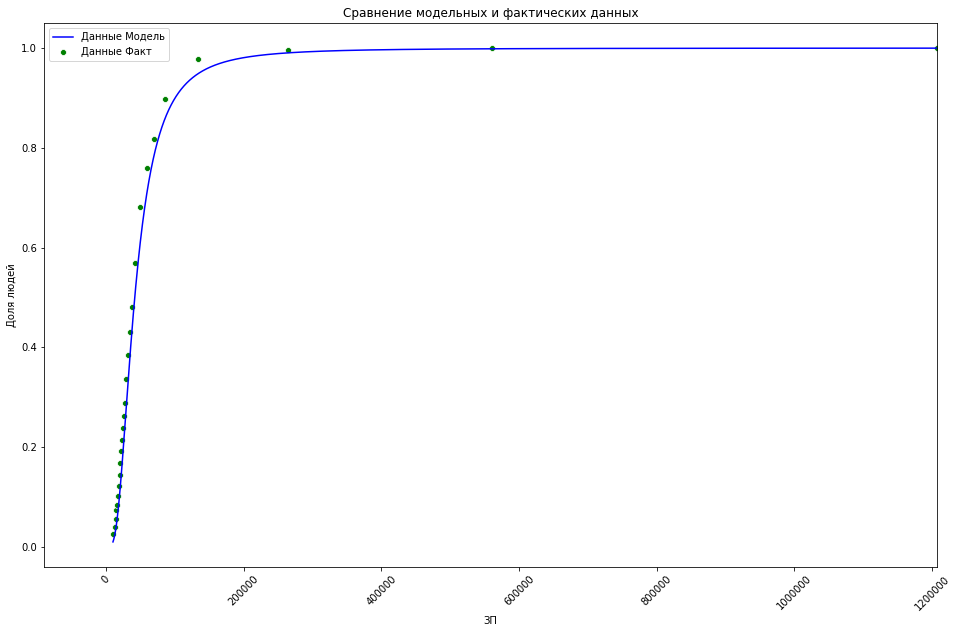

In [51]:
# a_opt_new = 17.72548374150287
# b_opt_new = 10.578088107154558
# p_opt_new = 2.2042595359410027
# q_opt_new = 1.9788653694494196

def gb2_cdf(x, a, b, p, q):
        term = (x / b) ** a
        return betainc(p, q, term / (1 + term))
    
x_true = np.log(df_2021['Ср зп'])
y_true = df_2021['cumsum']

x_model = np.log(np.arange(df_2021['Ср зп'].min(), df_2021['Ср зп'].max(), dtype=np.int32))
y_model = gb2_cdf(x_model, a_opt_new, b_opt_new, p_opt_new, q_opt_new )


plt.figure(figsize=(16, 10))
    
sns.scatterplot(x=np.exp(x_true), y=y_true, color='green', label='Данные Факт')
    
sns.lineplot(x=np.exp(x_model), y=y_model, color='blue', label='Данные Модель')
    
plt.title(f'Сравнение модельных и фактических данных')
plt.xlabel('ЗП')
plt.ylabel('Доля людей')
plt.legend()
plt.xticks(rotation=45)
plt.xlim(df_2021['Ср зп'].min() - 100_000, df_2021['Ср зп'].max())
plt.show()

In [50]:
buckets = [(1, 100_000), (100_000.1, 200_000), (200_000.1, 400_000), (400_000.1, 1_000_000), (1_000_000, 15_000_001)]

result_2021 = []

for start, end in buckets:
        bucket_fot, bucket_num_workers, bucket_avg_salary = range_stats(start, end, a_opt_new, b_opt_new, p_opt_new, q_opt_new, num_workers=27513690)
        result_2021.append({ 
            'bucket' : f'{start}-{end}',
            'fot' : bucket_fot, 
            'num_workers' : bucket_num_workers,
            'avg_salary' : bucket_avg_salary
        })

true_2021 = pd.DataFrame({
    'bucket' : [f'{start}-{end}' for start, end in buckets],
    'true_fot' : [1019722032699, 297162900607.2, 132787959244.4, 56637829332.3, 42168571452], 
    'true_num_workers' : [24676470, 2217132, 887636, 501879, 17103],
    'true_avg_salary' : [41323.65822, 134257.9, 264581.8, 560185.0, 2465506.671]
})      
       
result_2021 = pd.DataFrame(result_2021)
result = pd.merge(result_2021, true_2021, on='bucket')
result['fot_error'] = 1 - result['fot'] / result['true_fot']
result['num_workers_error'] = 1 - result['num_workers'] / result['true_num_workers']
result['avg_salary_error'] = 1 - result['avg_salary'] / result['true_avg_salary']
result


 CALCULATING 1-100000 


 CALCULATING 100000.1-200000 


 CALCULATING 200000.1-400000 


 CALCULATING 400000.1-1000000 


 CALCULATING 1000000-15000001 



,bucket,fot,num_workers,avg_salary,true_fot,true_num_workers,true_avg_salary,fot_error,num_workers_error,avg_salary_error
0,1-100000,1.083862e+12,2.229372e+07,4.861736e+04,1.019722e+12,24676470,4.132366e+04,-0.062900,0.096559,-0.176502
1,100000.1-200000,5.736885e+11,4.307746e+06,1.331760e+05,2.971629e+11,2217132,1.342579e+05,-0.930552,-0.942936,0.008058
2,200000.1-400000,2.064346e+11,7.993958e+05,2.582380e+05,1.327880e+11,887636,2.645818e+05,-0.554619,0.099410,0.023977
3,400000.1-1000000,5.678239e+10,1.061714e+05,5.348132e+05,5.663783e+10,501879,5.601850e+05,-0.002552,0.788452,0.045292
4,1000000-15000001,9.749940e+09,6.528087e+03,1.493308e+06,4.216857e+10,17103,2.465507e+06,0.768787,0.618308,0.394320
